In [12]:
%load_ext autoreload
%autoreload 2 

# Class generate jobs

In [1]:
from src.ProfileGenerator import ProfileGenerator
from src.JobGenerator import JobGenerator

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#Generate file
LOAD_FROM_FILE = False
MAX_RESOURCES = 4

prof_gen = ProfileGenerator(max_resources=MAX_RESOURCES)

if(LOAD_FROM_FILE):
    with open('profiles.json', 'r') as f:
        json_str = f.read()
        profiles = prof_gen.load_from_json(json_str)
else:
    profiles = prof_gen.generate(number_of_profiles=100, low_percent=0.6, med_percent=0.4, high_percent=0)

1.0
90 10 0 100
70 30 0 100
60 35 5 100


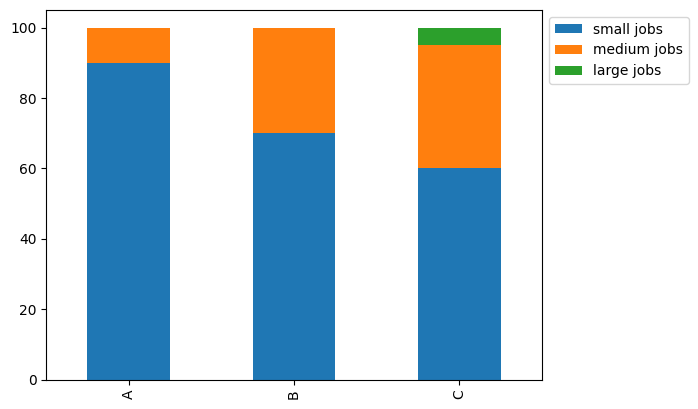

In [3]:
small  = [90, 70, 60]
medium = [10, 30, 35]
high   = [ 0,  0,  5]

index = ["A", "B", "C"]

df = pd.DataFrame({'small jobs': small, 'medium jobs': medium, 'large jobs': high}, index=index)
ax = df.plot.bar(stacked=True)
ax.legend(bbox_to_anchor=(1.0, 1.0))

print( 0.05 + 0.35 + 0.6)

profiles = []
for i in range(3):
    print(f"{small[i]} {medium[i]} {high[i]} {small[i] + medium[i] + high[i]}")
    profile_generator = ProfileGenerator(max_resources=MAX_RESOURCES)
    profiles.append(profile_generator.generate(number_of_profiles=100, low_percent=small[i]/100, med_percent=medium[i]/100, high_percent=high[i]/100))

# Generate Jobs

In [4]:
import networkx as nx
import numpy as np

def linearly_increasing_probability(t):
    return t / 3600  # Aumenta linealmente hasta 1 en una

def cyclic_poisson_probability(t, base_lambda=0.05, amplitude=0.04, period=3600):
    # Variar lambda con una función sinusoidal
    lambda_t = base_lambda + amplitude * np.sin(2 * np.pi * t / period)
    
    # Probabilidad de 0 eventos en el intervalo de tiempo t usando el lambda variante
    prob_0 = np.exp(-lambda_t)
    
    # Probabilidad de al menos 1 evento en el intervalo de tiempo t
    return 1 - prob_0

base_graph = nx.DiGraph()
# Añadir nodos y aristas principales
base_graph.add_edge(0, 1)
base_graph.add_edge(1, 2)
base_graph.add_edge(2, 3)
base_graph.add_edge(3, 4)

# Añadir dependencias cruzadas
base_graph.add_edge(0, 2)  # Nodo 0 también influye en el nodo 2
base_graph.add_edge(1, 3)  # Nodo 1 también influye en el nodo 3
base_graph.add_edge(2, 4)  # Nodo 2 también influye en el nodo 4

# Añadir nodos y aristas adicionales para mayor complejidad
base_graph.add_edge(0, 5)
base_graph.add_edge(5, 6)
base_graph.add_edge(6, 4)  # Nodo 6 influye en el nodo 4
base_graph.add_edge(3, 6)  # Nodo 3 también influye en el nodo 6

7686 2268
7546 2191
7175 2422


(0.0, 0.4)

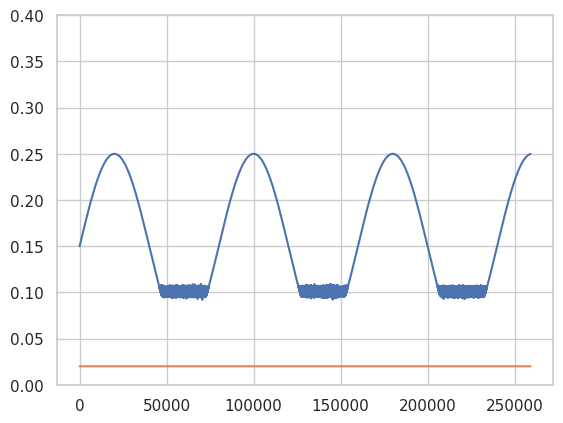

In [34]:
#plt.plot(np.arange(0,259200), cyclic_poisson_probability(np.arange(0,259200)))

def peaks_curve(t, period, amp: int = 0.1, ):
    return amp * np.sin(2 * np.pi * t / period)

sim_range  = np.arange(0,259200)
peak_curve = peaks_curve(sim_range, 8 * 10e3) + 0.15
noice = np.random.normal(0.001, 0.002, sim_range.shape) + 0.1
mixin = [ max(i, j) for i, j in zip(peak_curve, noice) ]

jobs_a, jobs_b = [], []
for i in profiles:
    job_generatorA = JobGenerator(i)
    job_generatorB = JobGenerator(i)
    
    job_generatorA.generate_variable_dag(lambda t: mixin[t], base_graph, check_interval=40, duration=3600 * 24 * 3)  
    job_generatorB.generate_variable_dag(lambda t:     0.05, base_graph, check_interval=40, duration=3600 * 24 * 3) 
    print( job_generatorA.job_count, job_generatorB.job_count )
    
    jobs_a.append( job_generatorA )
    jobs_b.append( job_generatorB )


plt.plot(mixin)
plt.plot([ 0.02 for i in sim_range ])

plt.ylim(0,0.4)

In [35]:
for caso, gen_a, gen_b in zip(["A", "B", "C"],  jobs_a, jobs_b):
    gen_a.generate_jobs_json(f"caso_variado_{caso}")
    gen_b.generate_jobs_json(f"caso_plano_{caso}")

#A.generate_jobs_json('10hills_workload')
#B.generate_jobs_json('no_hills_workload'

-> 7686
<- 7686
-> 2268
<- 2268
-> 7546
<- 7546
-> 2191
<- 2191
-> 7175
<- 7175
-> 2422
<- 2422


In [36]:
#A.visualize_with_subtime_annotations_dot()

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from scipy.interpolate import CubicSpline

def plot_jobs_per_hour(file_path, ax = None):
    with open(file_path, 'r') as file:
        data = json.load(file)
        
    # Extrayendo información de los trabajos
    jobs = data['jobs']
    start_times = [job['subtime'] for job in jobs]
    
    # Convertir segundos a horas
    start_times_in_hours = [time / 3600 for time in start_times]
    
    # Determinar el rango de horas
    min_hour = int(min(start_times_in_hours))
    max_hour = int(max(start_times_in_hours)) + 1  # +1 para incluir la última hora
    
    # Creando histograma
    bins = np.arange(min_hour, max_hour + 1)  # +1 para el límite final
    hist, bin_edges = np.histogram(start_times_in_hours, bins=bins)
    
    # Configuración de Seaborn
    sns.set(style="whitegrid")
    # plt.figure(figsize=(10, 6))
    
    # Interpolación spline cúbica para suavizar la curva
    cs = CubicSpline(bin_edges[:-1], hist, bc_type='natural')
    xs = np.linspace(min_hour, max_hour, 1000)
    
    # Dibujar la curva suavizada
    sns.lineplot(x=xs, y=cs(xs), ax=ax, color='b')

    # Configurar las marcas del eje x para que aparezcan en cada hora
    ax.set_xticks(bin_edges[:-1])

    
    # Configurar las etiquetas del eje x para que se muestren cada 4 horas
    #ax.gca().set_xticklabels([f"{int(i)}" if i % 4 == 0 else "" for i in bin_edges[:-1]])
    ax.set_xticklabels([f"{int(i)}" if i % 4 == 0 else "" for i in bin_edges[:-1]])

    ax.set_ylim(0,((max(cs(xs)) // 100)+1) * 100)
    #plt.title('Jobs Started per Hour')
    
    #plt.tight_layout()
    #plt.savefig('jobsxhour.png')
    #plt.show()
    return cs(xs)
# Usar la función para mostrar el gráfico por hora
#plot_jobs_per_hour('workload.json')

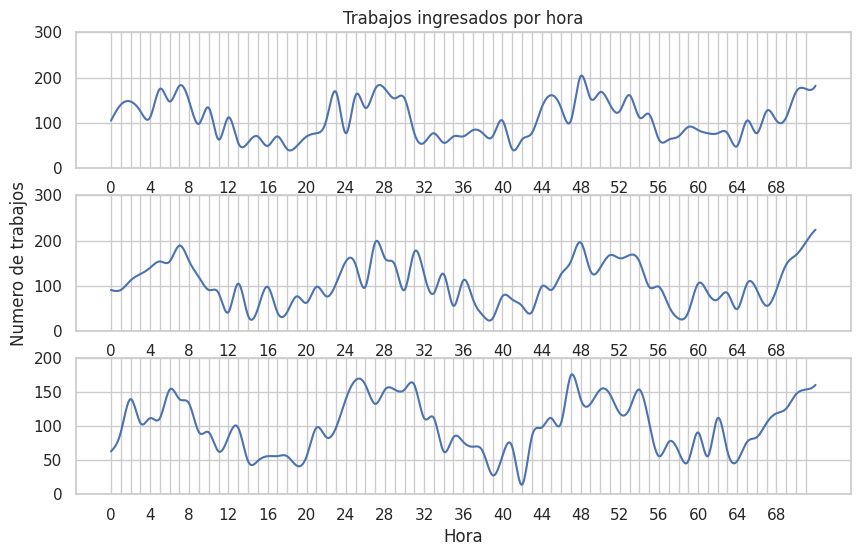

107.32405014813357 41.41049405019234 | 105.75193749629139 45.65544739837069 | 100.34358059638767 38.457312761352064


In [52]:
#plt.subplot(2,1,1)
#sns.set(style="whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))

#plt.tight_layout()

ax1.set_title('Trabajos ingresados por hora')
A = plot_jobs_per_hour('caso_variado_A.json', ax1)

ax2.set_ylabel('Numero de trabajos')
B = plot_jobs_per_hour('caso_variado_B.json', ax2)


ax3.set_xlabel('Hora')
C = plot_jobs_per_hour('caso_variado_C.json', ax3)

plt.show()
print(A.mean(), A.std(), "|", B.mean(), B.std(), "|", C.mean(), C.std())

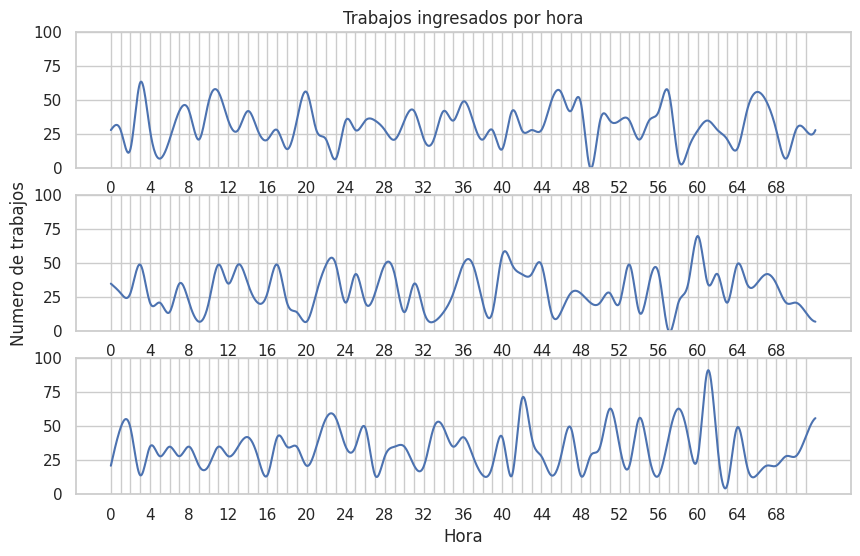

31.48814566413251 164.02690095770186 | 30.220954974469237 189.2347857646547 | 33.91715574291474 14.415556865416391


In [54]:
#plt.subplot(2,1,1)
#sns.set(style="whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))

#plt.tight_layout()

ax1.set_title('Trabajos ingresados por hora')
A = plot_jobs_per_hour('caso_plano_A.json', ax1)

ax2.set_ylabel('Numero de trabajos')
B = plot_jobs_per_hour('caso_plano_B.json', ax2)

ax3.set_xlabel('Hora')
C = plot_jobs_per_hour('caso_plano_C.json', ax3)

plt.show()
print(A.mean(), A.var(), "|", B.mean(), B.var(), "|", C.mean(), C.std())

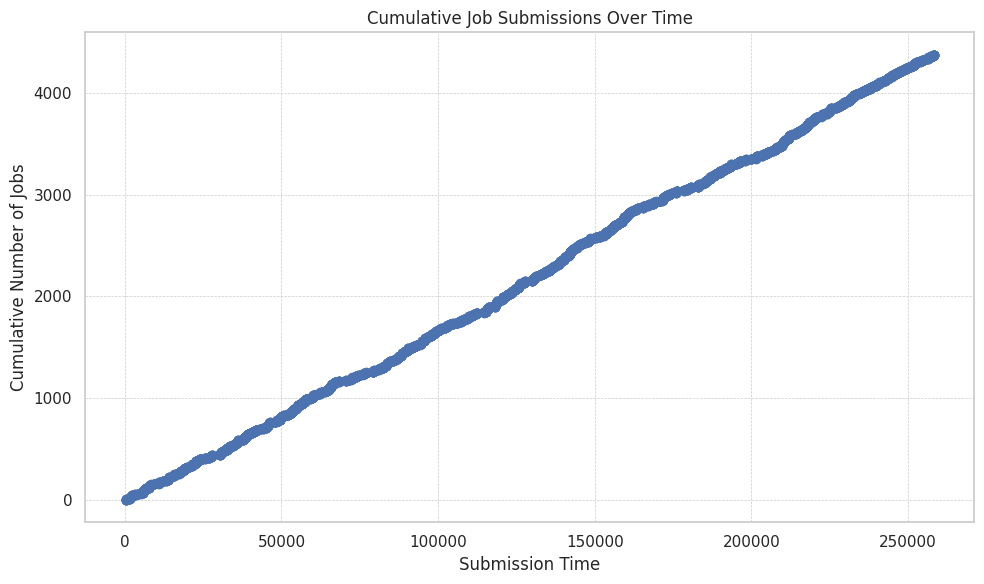

In [517]:
import numpy as np
import matplotlib.pyplot as plt

# Load the generated jobs from the JSON
with open("no_hills_workload.json", "r") as file:
    workload_data = json.load(file)

# Extract subtimes
subtimes = [job["subtime"] for job in workload_data["jobs"]]

# Sorting subtimes
sorted_subtimes = np.sort(subtimes)

# Create a cumulative count of jobs for each unique subtime
cumulative_counts = np.arange(1, len(sorted_subtimes) + 1)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_subtimes, cumulative_counts, marker='o', linestyle='-', color='b')
plt.title("Cumulative Job Submissions Over Time")
plt.xlabel("Submission Time")
plt.ylabel("Cumulative Number of Jobs")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [13]:
!cp workload.json ../../workloads/
!cp workload_dependencies.json ../../workloads/